# Part One: Raw Data

### EDA

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',', header=0)

In [2]:
# Print the first few rows of the DataFrame
print(df.head())

# Print the shape of the DataFrame
print(df.shape)

# Print the column names of the DataFrame
print(df.columns)

# Check for missing values in the DataFrame
print(df.isnull().sum())

         Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  Unnamed: 15  Unnamed: 16  
0  13.6  48.9  0.7578          NaN          NaN  
1  13.3  47.7  0

### Processing Data

In [3]:
# Drop unnecessary columns
df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)

# Convert Date and Time columns to datetime type and set as index
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Convert object type columns to float
df = df.astype(float)

# Replace -200 with NaN values
df.replace(-200, pd.NaT, inplace=True)

# Convert to numeric
df['CO(GT)'] = pd.to_numeric(df['CO(GT)'], errors='coerce')
df['PT08.S1(CO)'] = pd.to_numeric(df['PT08.S1(CO)'], errors='coerce')
df['NMHC(GT)'] = pd.to_numeric(df['NMHC(GT)'], errors='coerce')
df['PT08.S2(NMHC)'] = pd.to_numeric(df['PT08.S2(NMHC)'], errors='coerce')
df['NOx(GT)'] = pd.to_numeric(df['NOx(GT)'], errors='coerce')
df['PT08.S3(NOx)'] = pd.to_numeric(df['PT08.S3(NOx)'], errors='coerce')
df['NO2(GT)'] = pd.to_numeric(df['NO2(GT)'], errors='coerce')
df['PT08.S4(NO2)'] = pd.to_numeric(df['PT08.S4(NO2)'], errors='coerce')
df['PT08.S5(O3)'] = pd.to_numeric(df['PT08.S5(O3)'], errors='coerce')
df['T'] = pd.to_numeric(df['T'], errors='coerce')
df['RH'] = pd.to_numeric(df['RH'], errors='coerce')
df['AH'] = pd.to_numeric(df['AH'], errors='coerce')

# Resample data to hourly frequency and interpolate missing values
df = df.resample('H').interpolate()

# Save pre-processed data to a new CSV file
df.to_csv('AirQualityUCI_preprocessed.csv')

# Part Two: Preprocessed Data

In [4]:
import matplotlib.pyplot as plt

df = pd.read_csv('AirQualityUCI_preprocessed.csv', parse_dates=['Datetime'], index_col='Datetime')
df = df.fillna(method='ffill')

## Making a study on CO(GT) and C6H6(GT)

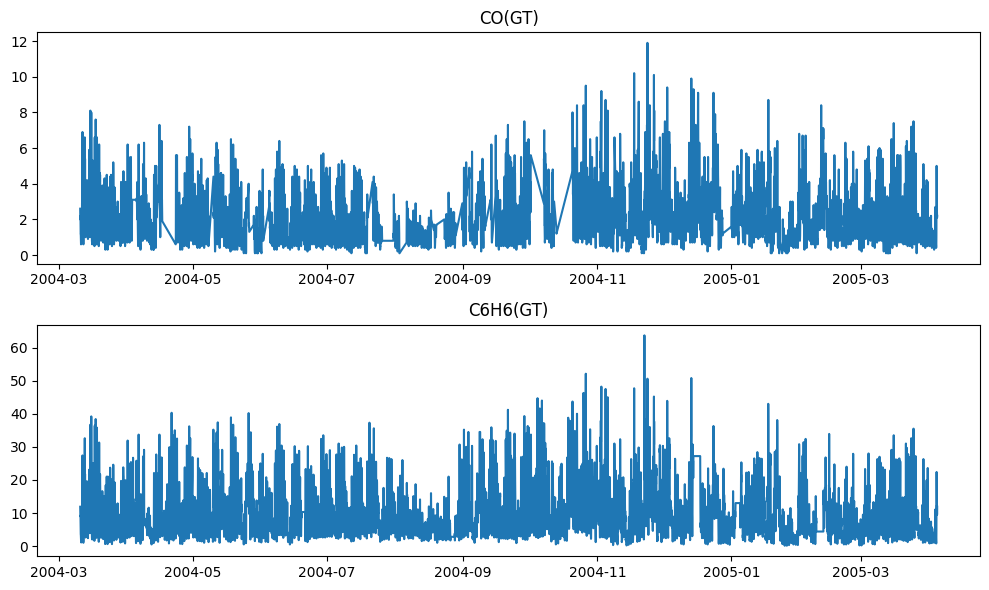

In [5]:
# Filter the dataset to only include CO(GT) and C6H6(GT) columns
df_co_c6h6 = df[['CO(GT)', 'C6H6(GT)']]

# Plot line plot for CO(GT) and C6H6(GT)
fig, axs = plt.subplots(df_co_c6h6.shape[1], figsize=(10, 6))
for i, col in enumerate(df_co_c6h6.columns):
    axs[i].plot(df_co_c6h6[col])
    axs[i].set_title(col)
plt.tight_layout()
plt.show()

## Study the Trend, Seasonal, and Residuals components

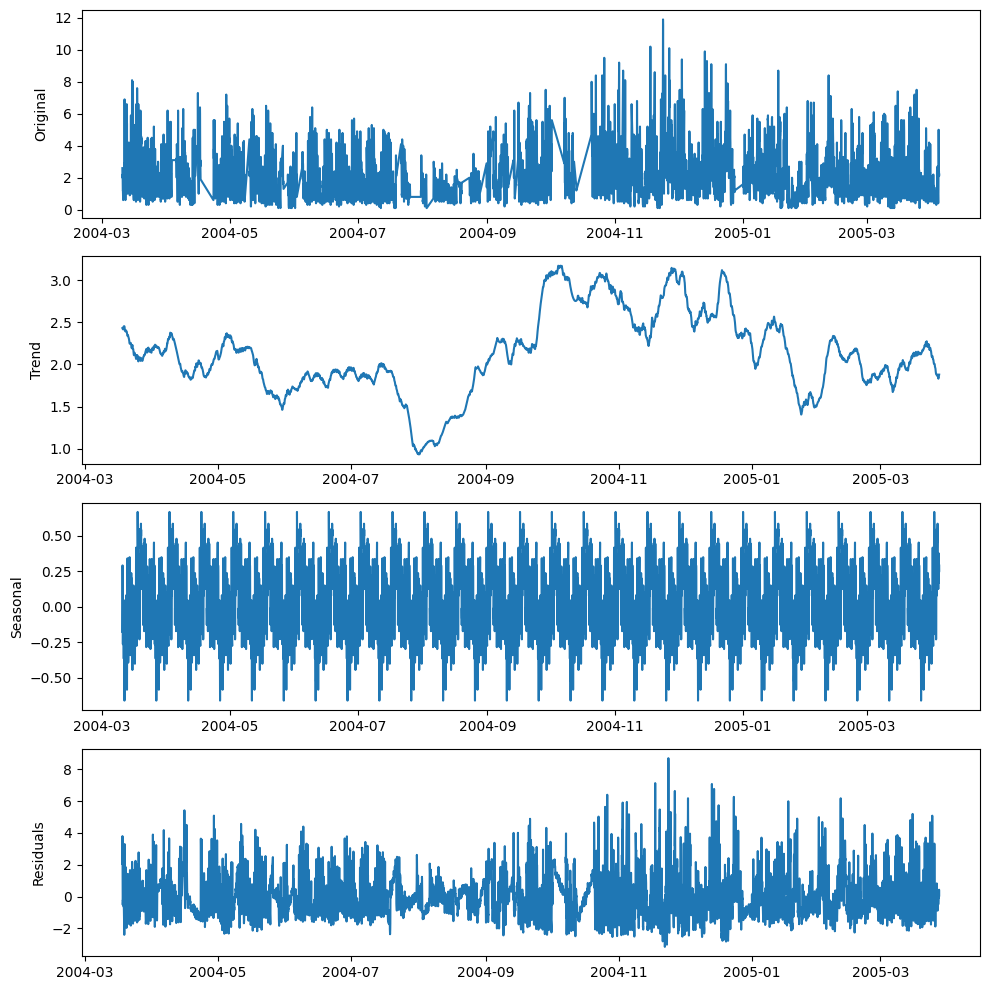

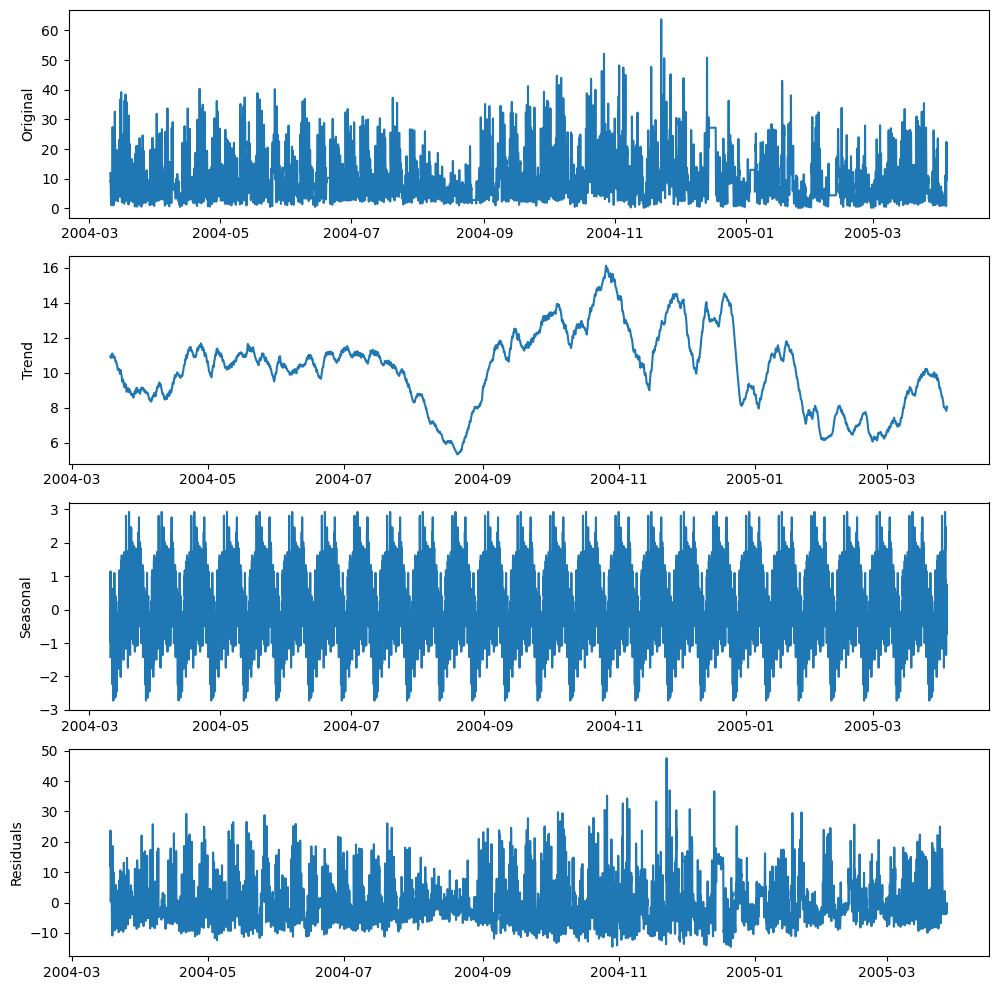

In [6]:
import statsmodels.api as sm

# Decompose CO(GT) and C6H6(GT) into trend, seasonal, and residuals components
decomposition_co = sm.tsa.seasonal_decompose(df_co_c6h6['CO(GT)'], model='additive', period=365)
decomposition_c6h6 = sm.tsa.seasonal_decompose(df_co_c6h6['C6H6(GT)'], model='additive', period=365)

# Plot the decomposition components for CO(GT)
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
axs[0].plot(df_co_c6h6['CO(GT)'])
axs[0].set_ylabel('Original')
axs[1].plot(decomposition_co.trend)
axs[1].set_ylabel('Trend')
axs[2].plot(decomposition_co.seasonal)
axs[2].set_ylabel('Seasonal')
axs[3].plot(decomposition_co.resid)
axs[3].set_ylabel('Residuals')
plt.tight_layout()
plt.show()

# Plot the decomposition components for C6H6(GT)
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
axs[0].plot(df_co_c6h6['C6H6(GT)'])
axs[0].set_ylabel('Original')
axs[1].plot(decomposition_c6h6.trend)
axs[1].set_ylabel('Trend')
axs[2].plot(decomposition_c6h6.seasonal)
axs[2].set_ylabel('Seasonal')
axs[3].plot(decomposition_c6h6.resid)
axs[3].set_ylabel('Residuals')
plt.tight_layout()
plt.show()

# Part Three: Applied Long Short Term Memory model to CO(GT) parameter

2023-02-25 02:32:34.853899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fold 1


2023-02-25 02:33:04.571861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
30/30 - 6s - loss: 2.4391 - val_loss: 0.8102 - 6s/epoch - 185ms/step
Epoch 2/50
30/30 - 2s - loss: 1.3058 - val_loss: 0.7407 - 2s/epoch - 72ms/step
Epoch 3/50
30/30 - 1s - loss: 1.1445 - val_loss: 0.6597 - 1s/epoch - 37ms/step
Epoch 4/50
30/30 - 1s - loss: 1.0165 - val_loss: 0.5866 - 854ms/epoch - 28ms/step
Epoch 5/50
30/30 - 1s - loss: 0.9005 - val_loss: 0.5225 - 831ms/epoch - 28ms/step
Epoch 6/50
30/30 - 1s - loss: 0.7981 - val_loss: 0.4570 - 898ms/epoch - 30ms/step
Epoch 7/50
30/30 - 2s - loss: 0.7151 - val_loss: 0.4027 - 2s/epoch - 65ms/step
Epoch 8/50
30/30 - 2s - loss: 0.6519 - val_loss: 0.3660 - 2s/epoch - 73ms/step
Epoch 9/50
30/30 - 2s - loss: 0.6044 - val_loss: 0.3461 - 2s/epoch - 83ms/step
Epoch 10/50
30/30 - 3s - loss: 0.5736 - val_loss: 0.3246 - 3s/epoch - 95ms/step
Epoch 11/50
30/30 - 3s - loss: 0.5396 - val_loss: 0.3098 - 3s/epoch - 92ms/step
Epoch 12/50
30/30 - 1s - loss: 0.5227 - val_loss: 0.2963 - 1s/epoch - 43ms/step
Epoch 13/50
30/30 - 1s - loss: 0.4921 -

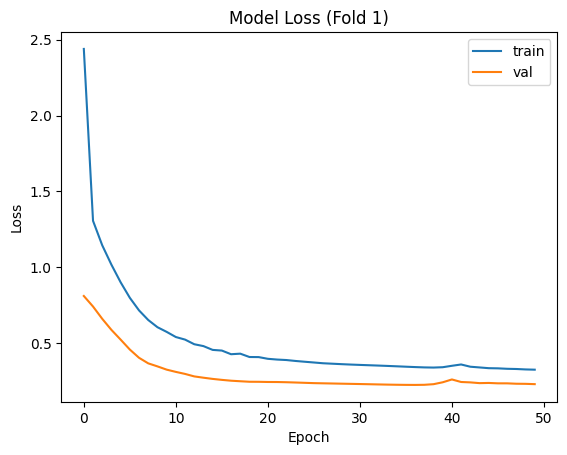

Fold 2
Epoch 1/50
59/59 - 8s - loss: 1.4673 - val_loss: 1.3110 - 8s/epoch - 138ms/step
Epoch 2/50
59/59 - 1s - loss: 0.9171 - val_loss: 1.0213 - 1s/epoch - 22ms/step
Epoch 3/50
59/59 - 1s - loss: 0.7070 - val_loss: 0.8497 - 1s/epoch - 22ms/step
Epoch 4/50
59/59 - 2s - loss: 0.5600 - val_loss: 0.6514 - 2s/epoch - 33ms/step
Epoch 5/50
59/59 - 2s - loss: 0.4681 - val_loss: 0.5367 - 2s/epoch - 27ms/step
Epoch 6/50
59/59 - 1s - loss: 0.4156 - val_loss: 0.4543 - 1s/epoch - 23ms/step
Epoch 7/50
59/59 - 3s - loss: 0.3833 - val_loss: 0.4123 - 3s/epoch - 49ms/step
Epoch 8/50
59/59 - 2s - loss: 0.3646 - val_loss: 0.3950 - 2s/epoch - 28ms/step
Epoch 9/50
59/59 - 1s - loss: 0.3540 - val_loss: 0.3933 - 1s/epoch - 23ms/step
Epoch 10/50
59/59 - 1s - loss: 0.3473 - val_loss: 0.4002 - 1s/epoch - 21ms/step
Epoch 11/50
59/59 - 1s - loss: 0.3423 - val_loss: 0.4011 - 1s/epoch - 25ms/step
Epoch 12/50
59/59 - 2s - loss: 0.3373 - val_loss: 0.3925 - 2s/epoch - 30ms/step
Epoch 13/50
59/59 - 3s - loss: 0.3317 - v

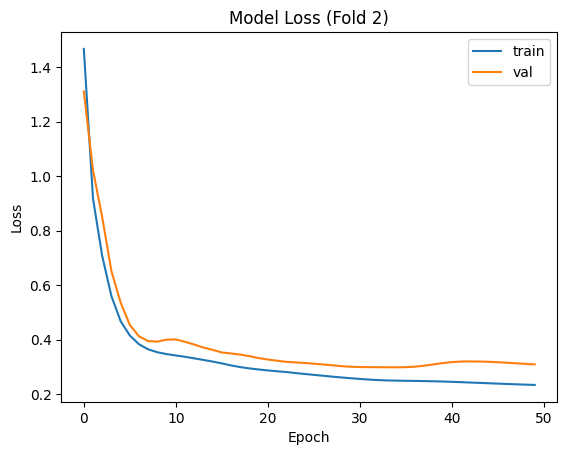

Fold 3
Epoch 1/50
88/88 - 5s - loss: 1.6778 - val_loss: 2.1352 - 5s/epoch - 57ms/step
Epoch 2/50
88/88 - 2s - loss: 0.8945 - val_loss: 1.4005 - 2s/epoch - 22ms/step
Epoch 3/50
88/88 - 2s - loss: 0.6591 - val_loss: 1.0034 - 2s/epoch - 28ms/step
Epoch 4/50
88/88 - 2s - loss: 0.5148 - val_loss: 0.8228 - 2s/epoch - 20ms/step
Epoch 5/50
88/88 - 2s - loss: 0.4365 - val_loss: 0.7280 - 2s/epoch - 19ms/step
Epoch 6/50
88/88 - 2s - loss: 0.3922 - val_loss: 0.6779 - 2s/epoch - 20ms/step
Epoch 7/50
88/88 - 2s - loss: 0.3671 - val_loss: 0.6515 - 2s/epoch - 20ms/step
Epoch 8/50
88/88 - 2s - loss: 0.3534 - val_loss: 0.6349 - 2s/epoch - 19ms/step
Epoch 9/50
88/88 - 2s - loss: 0.3395 - val_loss: 0.6268 - 2s/epoch - 20ms/step
Epoch 10/50
88/88 - 2s - loss: 0.3332 - val_loss: 0.6236 - 2s/epoch - 22ms/step
Epoch 11/50
88/88 - 2s - loss: 0.3247 - val_loss: 0.6115 - 2s/epoch - 19ms/step
Epoch 12/50
88/88 - 2s - loss: 0.3191 - val_loss: 0.6078 - 2s/epoch - 20ms/step
Epoch 13/50
88/88 - 2s - loss: 0.3142 - va

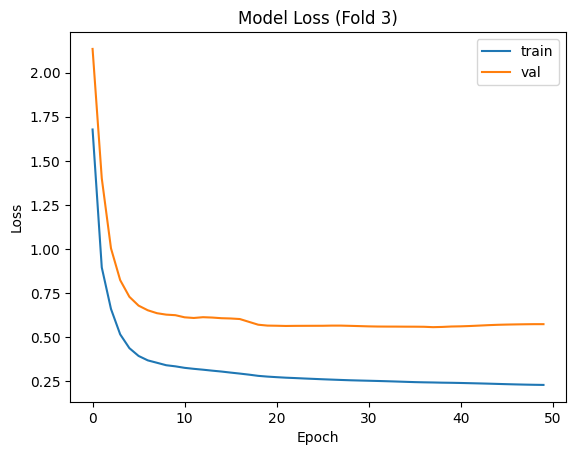

Average MSE: 0.37042599287841593
Average RMSE: 0.5972345240392967
Average MAE: 0.39776265764732316


In [7]:
# Import required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Split data into training and test sets
train_data = df_co_c6h6['CO(GT)'].iloc[:int(0.8*len(df_co_c6h6['CO(GT)']))]
test_data = df_co_c6h6['CO(GT)'].iloc[int(0.8*len(df_co_c6h6['CO(GT)'])):]

# Prepare data for LSTM model
def prepare_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data)-time_steps-1):
        X.append(data[i:(i+time_steps)])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set number of time steps and prepare data
time_steps = 24
X_train, y_train = prepare_data(train_data.values, time_steps)
X_test, y_test = prepare_data(test_data.values, time_steps)

# Define LSTM model
def create_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=(time_steps, 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

# Perform 3-fold cross validation
tscv = TimeSeriesSplit(n_splits=3)
mse_scores = []
rmse_scores = []
mae_scores = []

for fold, (train_index, val_index) in enumerate(tscv.split(X_train), 1):
    print('Fold', fold)
    # Split data into training and validation sets
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    
    # Create model
    model = create_model()
    
    # Train model
    history = model.fit(X_train_cv.reshape((X_train_cv.shape[0], X_train_cv.shape[1], 1)), y_train_cv,
                    epochs=50, batch_size=64, verbose=2, shuffle=False, 
                    validation_data=(X_val_cv.reshape((X_val_cv.shape[0], X_val_cv.shape[1], 1)), y_val_cv))
    
    # Make predictions on validation set
    predictions = model.predict(X_val_cv.reshape((X_val_cv.shape[0], X_val_cv.shape[1], 1)))
    
    # Reshape predictions and validation data
    predictions = predictions.reshape(predictions.shape[0])
    y_val_cv = y_val_cv.reshape(y_val_cv.shape[0])
    
    # Calculate MSE, RMSE, and MAE for validation set
    mse = mean_squared_error(y_val_cv, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val_cv, predictions)
    
    # Append scores to lists
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    
    # Plot training and validation loss over epochs
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'Model Loss (Fold {fold})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Print average MSE, RMSE, and MAE scores for 3-fold cross validation
print('Average MSE:', np.mean(mse_scores))
print('Average RMSE:', np.mean(rmse_scores))
print('Average MAE:', np.mean(mae_scores))

58/58 [==============================] - 0s 6ms/step
Mean Squared Error (MSE): 0.3694
Root Mean Squared Error (RMSE): 0.6078
Mean Absolute Error (MAE): 0.4360


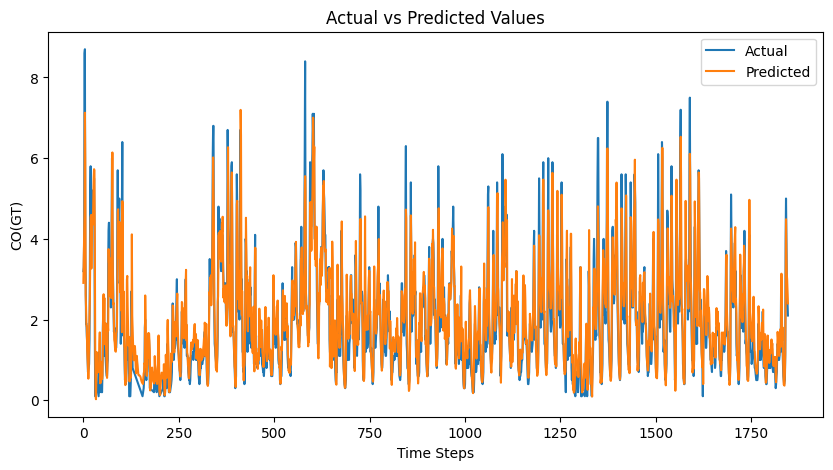

In [8]:
# Make predictions on test set
predictions = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))

# Reshape predictions and test data
predictions = predictions.reshape(predictions.shape[0])
y_test = y_test.reshape(y_test.shape[0])

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Plot actual vs predicted values for test set
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_test, label='Actual')
ax.plot(predictions, label='Predicted')
ax.set_title('Actual vs Predicted Values')
ax.set_xlabel('Time Steps')
ax.set_ylabel('CO(GT)')
ax.legend()
plt.show()


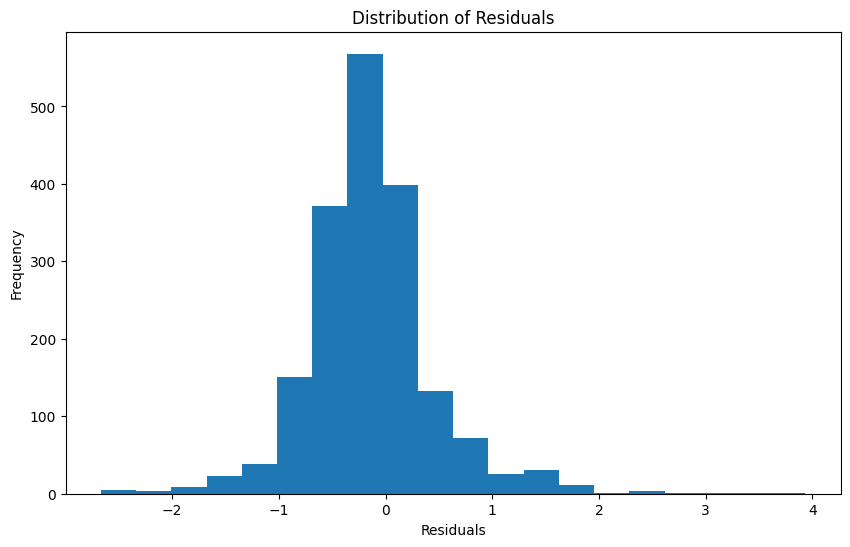

In [9]:
# Calculate residuals for test set
residuals = y_test - predictions

# Plot distribution of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()